# Li+ Analysis Using pdbionsurvey

`pdbionsurvey` is a library that seeks to quantify the interactions between cations and polarized atoms in proteins, namely oxygen. The library attempts to simplify the amount of ad hoc coding that must be done while still maintaining flexibility in its use. Here, we will demonstrate the use of `pdbionsurvey` in analyzing cation/oxygen interactions in proteins. We will use lithium ions (Li+) as our example ion since it is less common than Na+ or K+ which decreases the amount of data to process and therefore the computation time.

### First Things First: imports and Variables

##### Necessary import statements
We need to import a few packages to make things more readily useable.

In [1]:
# import the library that is being demonstrated
import pdbionsurvey.coordination
import pdbionsurvey.collection
import pdbionsurvey.analysis

# needed to make protein universes
import MDAnalysis as mda

# needed to make and use sims
import mdsynthesis as mds

# needed for path definitions
import os

# needed for displaying plots
import matplotlib.pyplot as plt
%matplotlib inline

# needed for simplicity
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python2.7/dist-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


##### Path definitions

We should put all of our files in directories and sort them nicely. In general, these directories can live anywhere, which allows people to use the package to suit their own needs.

In [2]:
# directory for the pdbs
path = mds.Tree('/nfs/homes/kreidy/Projects/PDB_Ion_Survey/pdbs/')

# directory for the sims
# it is important that this directory is empty,
# otherwise, mislabeling may happen later
simdir = path['sims_folder/LI/']

# directory for DataFrames
datapath = path['dataframes']

In [3]:
simdir.trees[:3].draw()

1DGD/
 +-- Sim.000de767-2e37-4f81-bf2c-a47215820559.json
 +-- 1DGD.pdb
1E5K/
 +-- 1E5K.pdb
 +-- Sim.3a4dc6cb-7840-48ce-a8cc-60b40f951f6b.json
1H4C/
 +-- 1H4C.pdb
 +-- Sim.14da99a2-edb4-478f-8783-ce527ce6d11d.json


### Obtaining Data from the PDB

### Get PDB ids
We need to query the PDB for all of the PDB ids cooresponding to files that contain Li+ ions.

`pdbionsurvey.collection.get_pdb_ids` has other parameters that are left with their defaults:  
`containsProtein=True` will filter out any molecules that do not contain proteins,  
`containsDNA=False` will filter out any molecules that contain DNA (because it's set to false),  
`containsRna=False` will filter out any molecules that contain RNA,  
and `containsHybrid=False` will filter out any molecules that contain multiple molecule types.

In [4]:
# find and store the PDB ids
ids = pdbionsurvey.collection.get_pdb_ids('Li')

# display the number of PDB ids
print len(ids)

63


### Download .pdb files corresponding to PDB ids

Good to break up scripts into modules and functions to demonstrate how components work to produce data. Separating querying from analysis allows for more understanding and flexibility in use.

In [5]:
# download each .pdb file individually
for pdbid in ids:
    pdbionsurvey.collection.get_pdb_file(pdbid, path.abspath)

### Making Sims

We make sims using `mdsynthesis` to store our data so that we can easily access it in the future. We can use `pdbionsurvey.analysis.make_sims` to quickly make them consistently for the purpose of coorcination analysis.

In [6]:
pdbs = path.glob('*.pdb')
pdbs = pdbs[[pdb.name in [r + '.pdb' for r in ids] for pdb in pdbs]]

In [7]:
# make sims
sims = pdbionsurvey.analysis.make_sims(simdir, pdbs)

In [8]:
simdir.trees[:3].draw()

1DGD/
 +-- Sim.000de767-2e37-4f81-bf2c-a47215820559.json
 +-- 1DGD.pdb
1E5K/
 +-- 1E5K.pdb
 +-- Sim.3a4dc6cb-7840-48ce-a8cc-60b40f951f6b.json
1H4C/
 +-- 1H4C.pdb
 +-- Sim.14da99a2-edb4-478f-8783-ce527ce6d11d.json


### Making and Storing Radial Distribution Functions

We use MDAnalysis to create a protein Universe and to select the ions that we care about. From there, we can use `pdbionsurvey.coordination.en` to create a radial distribution function for each .pdb file. We then store our data as .csv files for easy access and sorting.

In [9]:
pdbionsurvey.analysis.define_universe(sims, pdbs)

In [10]:
simdir.trees[:3].draw()

1DGD/
 +-- Sim.000de767-2e37-4f81-bf2c-a47215820559.json
 +-- 1DGD.pdb
1E5K/
 +-- 1E5K.pdb
 +-- Sim.3a4dc6cb-7840-48ce-a8cc-60b40f951f6b.json
1H4C/
 +-- 1H4C.pdb
 +-- Sim.14da99a2-edb4-478f-8783-ce527ce6d11d.json


In [11]:
for i in sims:
    # make a protein Universe
    u = mda.Universe(i.universedef.topology)

    # select Li atoms
    ions = u.select_atoms('name LI')

    for ion in ions:
        # make radial distribution function
        df = pdbionsurvey.coordination.en(u, ion)
        
        # make directory if it doesn't exist
        i['coordination/LI/'].make()

        # store radial distribution function in .csv file
        df.to_csv(i['coordination/LI/{}.csv'.format(ion.number)].abspath)

In [12]:
sims[0].universedef.topology

u'/nfs/homes/kreidy/Projects/PDB_Ion_Survey/pdbs/1DGD.pdb'

In [13]:
sims[1].glob('*.pdb')[0].abspath

'/nfs/homes/kreidy/Projects/PDB_Ion_Survey/pdbs/sims_folder/LI/1E5K/1E5K.pdb'

In [14]:
mda.Universe(sims[1].glob('*.pdb')[0].abspath)

<Universe with 1599 atoms and 28 bonds>

In [16]:
simdir.trees[:3].draw()

1DGD/
 +-- Sim.000de767-2e37-4f81-bf2c-a47215820559.json
 +-- 1DGD.pdb
 +-- coordination/
     +-- LI/
         +-- 3248.csv
1E5K/
 +-- coordination/
 |   +-- LI/
 |       +-- 1423.csv
 +-- 1E5K.pdb
 +-- Sim.3a4dc6cb-7840-48ce-a8cc-60b40f951f6b.json
1H4C/
 +-- 1H4C.pdb
 +-- coordination/
 |   +-- LI/
 |       +-- 1423.csv
 +-- Sim.14da99a2-edb4-478f-8783-ce527ce6d11d.json


### Labeling Sims

We should tag all of the sims with the ions they contain, as well as add categories for resolution information and for whether or not water is explicitly contained in the file.

In [17]:
# label sims
pdbionsurvey.analysis.sim_labeling(sims, ionname='Li')

### Collecting Sims

Using mdsynthesis, we can create a bundle of all of the sims in simdir. We already have this bundle in `sims`, but we might want to do this if we have other sims in our sim directory, or if we want to grab them later from another notebook.

We can then sort these sims using their new tags and categories.

In [18]:
# create a Bundle of sims in simdir
b = mds.discover(simdir)

### Radial Distribution: g(r)

A g(r) is a function relating the distance away from something to the density of something around it. In this case, a g(r) is the relationship between the distance away from a Li+ ion and the density of oxygen atoms. Each point on the graph that we are making can be visualized as a sphere around the ion with the density of oxygens corresponding to the height of the point.

In [19]:
m, denses = pdbionsurvey.coordination.gee(b, 'LI')

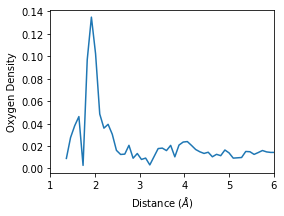

In [20]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Distance ($\AA$)')
ax.set_ylabel('Oxygen Density')
ax.set_xlim((1,6))
ax.plot(m, denses)

### Finding Peaks

It may also be useful to find where these solvation shells are exactly. By finding the peaks and troughs of a radial density distribution function, we can see in what bands most of the oxygen atoms lie. The troughs, where relatively few oxygen atoms are, can therefore be used as one boundary of a solvation shell.

In [21]:
# get peak information
m, dense, peaks, mins = pdbionsurvey.analysis.get_peaks(b, 'Li', mindist=.2)

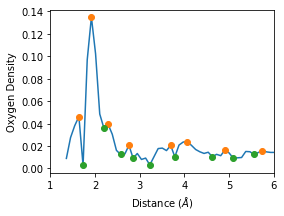

In [22]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
ax.set_xlim((1, 6))
ax.set_xlabel('Distance ($\AA$)')
ax.set_ylabel('Oxygen Density')
ax.plot(m, dense)
ax.plot(m[peaks], dense[peaks], 'o')
ax.plot(m[mins], dense[mins], 'o')

### Closest Oxygen Distances

It is useful in some applications to know the average distance of the n$^\text{th}$ closest oxygen atom to the ion, particularly for those n's that correspond to the oxygen atoms in the first solvation shell.

Here we'll look at the closest six oxygen atoms to all of the Li+ ions in our sample.

In [23]:
# get closest oxygen information
oxys = pdbionsurvey.analysis.closest_oxy_distance(b, ['Li'], [2.5])

In [24]:
oxys[0].head()

,1,2,3,4,5,6
5FOH_1670,2.039432,3.572074,3.814925,3.961905,4.216130,4.444806
3C31_4337,1.859302,1.883259,1.955296,1.990423,3.533900,3.684128
3C31_4368,1.732123,1.932449,2.013333,2.037104,3.493592,3.502325
3QEU_6862,1.813947,1.859980,1.889302,1.918563,2.017432,2.207255
2I3I_1531,1.805357,1.815221,1.856789,3.522641,4.163842,4.178793


In [25]:
len(oxys[0])

89

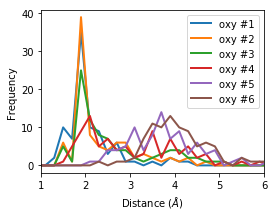

In [26]:
ax = pdbionsurvey.analysis.graph_closest_oxy_distances(oxys[0], axlim=(1, 6))

# Conclusion

We can see here that some of the plots that we generated are rather choppy. This is most likely because of the relative lack of data for Li+. It is important to note that the emphasis here should not be on the science but on the computation and using the library, so we won't discuss the analysis of our results with too much depth. It is important to know that the library is structured in such a way that it has a lot of dependency on packages like `MDAnalysis`, `mdsynthesis`, and `peakutils`, and it makes a lot of assumptions about the structure of the Sims it uses, but once these other packages are installed, `pdbionsurvey`  makes it easy to make Sims in the way that it wants.